## Instructions for use
The document needs to be run with the appropriate

## Baseline Model
Uses a BiLSTM with pretrained GloVe embeddings(300 dimension).
The aspect term embedding is obtained and concatenated with the cell output of the BiLSTM layer. 

In [ ]:
# import os
# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir('/content/drive/MyDrive/Colab Notebooks/CS4248/Project')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
from collections import Counter

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence


from sklearn.metrics import classification_report,accuracy_score,f1_score,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
sns.set()
torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import spacy
import spacy.cli
spacy.cli.download('en_core_web_md')

nlp = spacy.load('en_core_web_md')

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [ ]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

## Load Glove Embeddings

In [ ]:
'''
Uncomment the following lines to download the GloVe 6B word embedding files.
The default location for download is the folder data/glove 
'''
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip -d ./data/glove
# !ls -lat ./data/glove

In [ ]:
WORD_EMBEDDING_SIZE=300

In [ ]:

class WordEmbeddings():
    def __init__(self,path):
        self.word2idx={'<pad>':0}
        self.idx2word=['<pad>']
        self.embeddings=[np.zeros(WORD_EMBEDDING_SIZE)]

        self.load_vectors(path)

    def load_vectors(self,path):
        with open(path,'r') as f:
            for idx,line in enumerate(f,start=len(self.embeddings)):
                values = line.split()
                word = values[0]
                vector = np.asarray(line.split()[1:],'float32')

                if word not in self.word2idx:
                    self.word2idx[word]=idx
                    self.idx2word.append(word)
                    self.embeddings.append(vector)
                
        self.embeddings = torch.tensor(np.array(self.embeddings))

        self.idx2word.append('<unk>')
        self.word2idx['<unk>'] = len(self.idx2word)-1
        self.embeddings = torch.cat((self.embeddings,self.embeddings.mean(dim=0).unsqueeze(0)),dim=0).float()
        


vocab = WordEmbeddings(path='./data/glove/glove.6B.300d.txt')

## Load dataframe

In [ ]:
from ast import literal_eval

def split_string(text,delimiter=None):
    return literal_eval(text)

converters = {
    'AspectTerms':lambda x: literal_eval(x),
    'AspectTermsPolarity':lambda x: literal_eval(x),
    'TextWithPOS': lambda x:literal_eval(x),
    'FixedTextWithPOS': lambda x:literal_eval(x),
    'FixedTexttWithPOSReplaced': lambda x:literal_eval(x),
    'AspectTermsSpan': lambda x:literal_eval(x)
    }

In [ ]:
df = pd.read_csv('./data/pre_processed.csv',converters=converters)
df.drop('Unnamed: 0',axis=1,inplace=True)

In [ ]:
df.head()

,ID,RawText,AspectTerms,AspectTermsPolarity,AspectTermsSpan,TextWithPOS,FixedTextWithPOS,Past,Future,Adj,Adv,Pronoun,Noun,Verb,Pos_lex,Neg_lex,FixedTexttWithPOSReplaced,TextWithIOB
0,3121,But the staff was so horrible to us.,[staff],[negative],"[(8, 13)]","[(But, CC), (the, DT), (staff, NN), (was, VBD)...","[(But, CC), (the, DT), (staff, NN), (be, VBD),...",1.0,0.000000,0.111111,0.111111,0.111111,0.111111,0.111111,0.00,0.50,"[(But, CC), (the, DT), (staff, NN), (be, VBD),...","[('But', 'O'), ('the', 'O'), ('staff', 'B-NP')..."
1,2777,"To be completely fair, the only redeeming fact...",[food],[positive],"[(57, 61)]","[(To, TO), (be, VB), (completely, RB), (fair, ...","[(To, TO), (be, VB), (completely, RB), (fair, ...",0.5,0.250000,0.096774,0.096774,0.000000,0.193548,0.129032,0.50,0.25,"[(To, TO), (be, VB), (completely, RB), (fair, ...","[('To', 'O'), ('be', 'O'), ('completely', 'O')..."
2,1634,"The food is uniformly exceptional, with a very...","[food, kitchen, menu]","[positive, positive, neutral]","[(4, 8), (55, 62), (141, 145)]","[(The, DT), (food, NN), (is, VBZ), (uniformly,...","[(The, DT), (food, NN), (be, VBZ), (uniformly,...",0.0,0.250000,0.096774,0.129032,0.064516,0.129032,0.129032,0.75,0.00,"[(The, DT), (food, NN), (be, VBZ), (uniformly,...","[('The', 'O'), ('food', 'B-NP'), ('is', 'O'), ..."
3,2534,Where Gabriela personaly greets you and recomm...,[],[],[],"[(Where, WRB), (Gabriela, NNP), (personal, JJ)...","[(Where, WRB), (Gabriela, NNP), (personal, JJ)...",0.0,0.000000,0.083333,0.000000,0.166667,0.166667,0.166667,0.50,0.00,"[(Where, WRB), (<PNOUN>, NNP), (personal, JJ),...","[('Where', 'O'), ('Gabriela', 'B-NP'), ('perso..."
4,583,"For those that go once and don't enjoy it, all...",[],[],[],"[(For, IN), (those, DT), (that, WDT), (go, VBP...","[(For, IN), (those, DT), (that, WDT), (go, VBP...",0.0,0.142857,0.000000,0.166667,0.166667,0.000000,0.291667,1.00,0.00,"[(For, IN), (those, DT), (that, WDT), (go, VBP...","[('For', 'O'), ('those', 'O'), ('that', 'O'), ..."


In [ ]:
def tokenizer(text):
    doc = nlp(text.lower())

    return [str(word) for word in doc]

def sentence2idx(tokens):
    return [vocab.word2idx[token] if token in vocab.word2idx else vocab.word2idx['<unk>'] for token in tokens]

In [ ]:
def plot_confusion_matrix(y_true,y_pred):
    mat = confusion_matrix(y_true, y_pred,labels=np.unique(y_true))
    sns.heatmap(mat, square = True, annot=True, fmt = "d", xticklabels=np.unique(y_true),yticklabels=np.unique(y_true),cmap='Blues')
    plt.xlabel("PREDICTED LABEL")
    plt.ylabel("TRUE LABEL")
    plt.show()

In [ ]:
df['tokens'] = df['RawText'].apply(tokenizer)

### Duplicate sentences for each aspect term

In [ ]:
def generate_dataset(df):
    rows_list=[]

    for idx,row in df.iterrows():
        
        for term_idx,term in enumerate(row['AspectTerms']):
            # rows_list.append([row['ID'],row['RawText'],term,row['AspectTermsPolarity'][term_idx],row['tokens'],row['AspectTermsSpan'],row['TextWithPOS'],row['FixedTextWithPOS']])
            new_row = list(row[~df.columns.isin(['AspectTerms', 'AspectTermsPolarity', 'AspectTermsSpan'])])
            new_row.insert(2,term)
            new_row.insert(3,row['AspectTermsPolarity'][term_idx])
            new_row.insert(4,row['AspectTermsSpan'][term_idx])
            rows_list.append(new_row)
            

    new_df=pd.DataFrame(rows_list,columns=df.columns.tolist())

    return new_df

In [ ]:
review_df = generate_dataset(df)
review_df = review_df[review_df['AspectTermsPolarity']!='conflict']

In [ ]:
le = LabelEncoder()

review_df['encoded_polarity_labels'] = le.fit_transform(review_df['AspectTermsPolarity'])


In [ ]:
review_df.head()

,ID,RawText,AspectTerms,AspectTermsPolarity,AspectTermsSpan,TextWithPOS,FixedTextWithPOS,Past,Future,Adj,Adv,Pronoun,Noun,Verb,Pos_lex,Neg_lex,FixedTexttWithPOSReplaced,TextWithIOB,tokens,encoded_polarity_labels
0,3121,But the staff was so horrible to us.,staff,negative,"(8, 13)","[(But, CC), (the, DT), (staff, NN), (was, VBD)...","[(But, CC), (the, DT), (staff, NN), (be, VBD),...",1.0,0.00,0.111111,0.111111,0.111111,0.111111,0.111111,0.00,0.50,"[(But, CC), (the, DT), (staff, NN), (be, VBD),...","[('But', 'O'), ('the', 'O'), ('staff', 'B-NP')...","[but, the, staff, was, so, horrible, to, us, .]",0
1,2777,"To be completely fair, the only redeeming fact...",food,positive,"(57, 61)","[(To, TO), (be, VB), (completely, RB), (fair, ...","[(To, TO), (be, VB), (completely, RB), (fair, ...",0.5,0.25,0.096774,0.096774,0.000000,0.193548,0.129032,0.50,0.25,"[(To, TO), (be, VB), (completely, RB), (fair, ...","[('To', 'O'), ('be', 'O'), ('completely', 'O')...","[to, be, completely, fair, ,, the, only, redee...",2
2,1634,"The food is uniformly exceptional, with a very...",food,positive,"(4, 8)","[(The, DT), (food, NN), (is, VBZ), (uniformly,...","[(The, DT), (food, NN), (be, VBZ), (uniformly,...",0.0,0.25,0.096774,0.129032,0.064516,0.129032,0.129032,0.75,0.00,"[(The, DT), (food, NN), (be, VBZ), (uniformly,...","[('The', 'O'), ('food', 'B-NP'), ('is', 'O'), ...","[the, food, is, uniformly, exceptional, ,, wit...",2
3,1634,"The food is uniformly exceptional, with a very...",kitchen,positive,"(55, 62)","[(The, DT), (food, NN), (is, VBZ), (uniformly,...","[(The, DT), (food, NN), (be, VBZ), (uniformly,...",0.0,0.25,0.096774,0.129032,0.064516,0.129032,0.129032,0.75,0.00,"[(The, DT), (food, NN), (be, VBZ), (uniformly,...","[('The', 'O'), ('food', 'B-NP'), ('is', 'O'), ...","[the, food, is, uniformly, exceptional, ,, wit...",2
4,1634,"The food is uniformly exceptional, with a very...",menu,neutral,"(141, 145)","[(The, DT), (food, NN), (is, VBZ), (uniformly,...","[(The, DT), (food, NN), (be, VBZ), (uniformly,...",0.0,0.25,0.096774,0.129032,0.064516,0.129032,0.129032,0.75,0.00,"[(The, DT), (food, NN), (be, VBZ), (uniformly,...","[('The', 'O'), ('food', 'B-NP'), ('is', 'O'), ...","[the, food, is, uniformly, exceptional, ,, wit...",1


In [ ]:
class ReviewData(Dataset):
    def __init__(self,tokens,aspect_term,aspect_polarity):
        self.tokens=tokens
        self.aspect_term=aspect_term
        self.aspect_polarity = aspect_polarity

    def __len__(self):
        return len(self.aspect_polarity)

    def __getitem__(self, idx):
        sentence_idx = torch.tensor(sentence2idx(self.tokens[idx]),dtype=torch.long)
        aspect_idx = torch.tensor(sentence2idx([self.aspect_term[idx]]),dtype=torch.long)
        aspect_polarity = torch.tensor(self.aspect_polarity[idx],dtype=torch.long)

        return (sentence_idx,aspect_idx,aspect_polarity)

def collate_fn(batch):
    batch.sort(key=lambda x: len(x[0]), reverse=True)
    lens = [len(x[0])for x in batch]
    terms_list=[]
    polarity_list=[]
    padded = pad_sequence([x[0] for x in batch],batch_first=True)
    
    
    for tokens,aspect,polarity in batch:
        terms_list.append(aspect)
        polarity_list.append(polarity)
        # print('Review ID: ',review_id)
        # print('Length: ',len(tokens))
        # print('Aspect: ',aspect)
        # print('Polarity: ',polarity)
    
    return padded,torch.stack(terms_list,dim=0),torch.stack(polarity_list,dim=0),lens

### Train and test sets

In [ ]:
label_counts = review_df['AspectTermsPolarity'].value_counts()
dict(label_counts)


{'negative': 807, 'neutral': 637, 'positive': 2164}

In [ ]:
train_df,val_df = train_test_split(review_df, test_size=0.3, random_state=42,stratify=review_df['encoded_polarity_labels'])

In [ ]:
train_dataset = ReviewData(train_df['tokens'].values,train_df['AspectTerms'].values,train_df['encoded_polarity_labels'].values)
val_dataset = ReviewData(val_df['tokens'].values,val_df['AspectTerms'].values,val_df['encoded_polarity_labels'].values)

In [ ]:
BATCH_SIZE = 32

In [ ]:
train_loader = DataLoader(train_dataset,collate_fn=collate_fn,batch_size=BATCH_SIZE,drop_last=False,shuffle=True,worker_init_fn=seed_worker,
    generator=g)

In [ ]:
val_loader = DataLoader(val_dataset,collate_fn=collate_fn,batch_size=BATCH_SIZE,drop_last=False,shuffle=False,worker_init_fn=seed_worker,
    generator=g)

## BiLSTM

In [ ]:
class Encoder(nn.Module):
    def __init__(self,input_size,hidden_size,output_size,p=0.2,bidirectional=False,pretrained=True):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.p = p
        
        
        if pretrained==False:
            self.embedding = nn.Embedding(self.input_size,self.hidden_size)
        else:
            self.embedding =  nn.Embedding.from_pretrained(vocab.embeddings,freeze=True)
        self.sentence_encoder = nn.LSTM(self.hidden_size,self.hidden_size,bidirectional=bidirectional,batch_first=True)
        
        self.classifier = nn.Linear(self.hidden_size*5,self.output_size)

        self.dropout = nn.Dropout(p=self.p)
        

    def forward(self,x,aspect_terms,lens):
        
        sentence_emb = self.embedding(x)
        aspect_term_embedding = self.embedding(aspect_terms)
       
        packed_emb = pack_padded_sequence(sentence_emb,lengths=lens,enforce_sorted=True,batch_first=True)
        
        sentence_enc_packed, (h,c) = self.sentence_encoder(packed_emb)

        sentence_out,sentence_lens = pad_packed_sequence(sentence_enc_packed,batch_first=True) 

        avg_pool = torch.mean(sentence_out, 1)
        max_pool, _ = torch.max(sentence_out, 1)
        sentence_out = torch.cat(( avg_pool, max_pool), 1)
        

        sentence_cell_state = torch.hstack((c[0],c[1]))
        classify_vector = torch.hstack((sentence_out,aspect_term_embedding.squeeze(1)))

        out = self.dropout(classify_vector)
        out = self.classifier(out)

        return out

### Plots

In [ ]:
def plot_data(x_1,x_2,x_label,y_label,title):
    plt.plot(x_1)
    plt.plot(x_2)
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

### Evaluate model

In [ ]:
def evaluate(model):
    model.eval()
    test_loss = 0
    total = 0
    samples=[]
    preds=[]
    with torch.no_grad():
        for x,aspect_terms,aspect_polarity,lens in val_loader:
            
            x = x.to(device)
            aspect_polarity = aspect_polarity.to(device)
            aspect_terms = aspect_terms.to(device)

            out = model(x,aspect_terms,lens)
            loss = criterion(out,aspect_polarity)

            test_loss += (loss.detach().item())
            total+=1

            samples.extend(aspect_polarity.cpu())
            preds.extend(torch.argmax(out,dim=1).cpu())

    val_f1 = f1_score(samples,preds,average='macro')
    val_acc = accuracy_score(samples,preds)

    print('\t\tEval Loss: {:.6f} \tAccuracy:{:.6f} \tF1: {:.6f}\n'.format(test_loss/total,accuracy_score(samples,preds),val_f1))
    total_loss = test_loss/total
    return total_loss,val_acc

### Train Model

In [ ]:
model = Encoder(vocab.embeddings.size(0),vocab.embeddings.size(1),len(label_counts),p=0.5,bidirectional=True,pretrained=True).to(device)

In [ ]:
device

device(type='cuda')

In [ ]:
optimizer = optim.Adam(model.parameters(),lr=3e-4)
criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
NUM_EPOCHS = 6

In [ ]:
def train(model=None):

    if model is None:
        model = Encoder(vocab.embeddings.size(0),vocab.embeddings.size(1),3,p=0.5,bidirectional=True,pretrained=True).to(device)
    train_loss_list=[]
    val_loss_list=[]
    train_acc_list=[]
    val_acc_list=[]

    for i in range(NUM_EPOCHS):

        model.train()
        samples=[]
        preds=[]
        running_loss=0
        num_batches=0

        for x,aspect_terms,aspect_polarity,lens in train_loader:

            x = x.to(device)
            aspect_polarity = aspect_polarity.to(device)
            aspect_terms = aspect_terms.to(device)

            optimizer.zero_grad()
            out = model(x,aspect_terms,lens)
            loss = criterion(out,aspect_polarity)

            loss.backward()
            running_loss+=loss.detach().item()
            optimizer.step()
            num_batches+=1

            samples.extend(aspect_polarity.cpu())
            preds.extend(torch.argmax(out,dim=1).cpu())

        total_loss = running_loss/num_batches
        train_loss_list.append(total_loss)

        train_acc = accuracy_score(samples,preds)
        train_acc_list.append(train_acc)
        train_f1 = f1_score(samples,preds,average='macro')

        print('Epoch: {} \tTrain Loss: {:.6f} \tAccuracy: {:.6f} \tF1: {:.6f}'.format(i+1, total_loss,train_acc,train_f1))
        val_loss,val_acc = evaluate(model)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)

    plot_data(train_loss_list,val_loss_list,'epoch','loss','model loss')
    plot_data(train_acc_list,val_acc_list,'epoch','accuracy','model accuracy')
    return model

Epoch: 1 	Train Loss: 0.936751 	Accuracy: 0.597624 	F1: 0.273756
		Eval Loss: 0.861391 	Accuracy:0.630656 	F1: 0.345766

Epoch: 2 	Train Loss: 0.785889 	Accuracy: 0.649901 	F1: 0.444011
		Eval Loss: 0.750770 	Accuracy:0.672207 	F1: 0.483752

Epoch: 3 	Train Loss: 0.706270 	Accuracy: 0.704554 	F1: 0.559030
		Eval Loss: 0.713823 	Accuracy:0.709141 	F1: 0.589471

Epoch: 4 	Train Loss: 0.649778 	Accuracy: 0.734653 	F1: 0.620373
		Eval Loss: 0.678022 	Accuracy:0.722992 	F1: 0.603383

Epoch: 5 	Train Loss: 0.606683 	Accuracy: 0.756436 	F1: 0.656541
		Eval Loss: 0.727776 	Accuracy:0.675900 	F1: 0.583351

Epoch: 6 	Train Loss: 0.578469 	Accuracy: 0.769901 	F1: 0.677525
		Eval Loss: 0.676556 	Accuracy:0.726685 	F1: 0.590921



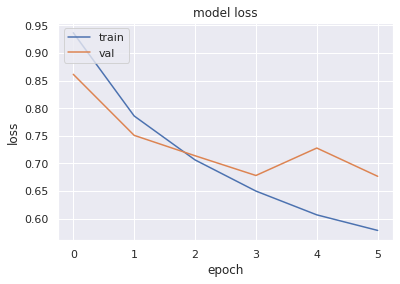

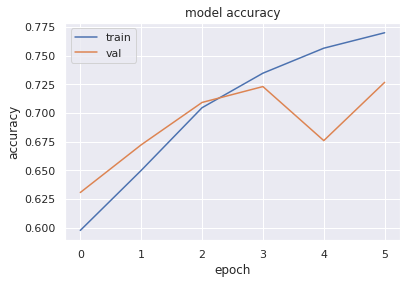

In [ ]:
model = train(model)

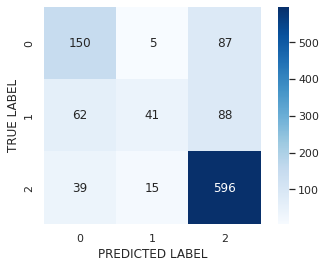

In [ ]:
tot = []
pre=[]
model.eval()
with torch.no_grad():
    for x,aspect_terms,aspect_polarity,lens in val_loader:

        x = x.to(device)
        aspect_polarity = aspect_polarity.to(device)
        aspect_terms = aspect_terms.to(device)

        out = model(x,aspect_terms,lens)
        loss = criterion(out,aspect_polarity)

        tot.extend(aspect_polarity.cpu())
        pre.extend(torch.argmax(out,dim=1).cpu())
    
plot_confusion_matrix(tot,pre)

## Test data

In [ ]:
test_df = pd.read_csv('./data/pre_processed_test.csv',converters=converters)
test_df.head()

,ID,RawText,AspectTerms,AspectTermsPolarity,AspectTermsSpan,RawTextTokenize,RawTextWithLabelIOB,TextWithPOS,TextWithPOSReplaced
0,32897564#894393#2,The bread is top notch as well.,[bread],[positive],"[(4, 9)]","['The', 'bread', 'is', 'top', 'notch', 'as', '...","[('The', 'O', None), ('bread', 'B', 'positive'...","[(The, DT), (bread, NN), (is, VBZ), (top, JJ),...","[('The', 'DT'), ('bread', 'NN'), ('is', 'VBZ')..."
1,33070600#670328#0,I have to say they have one of the fastest del...,[delivery times],[positive],"[(43, 57)]","['I', 'have', 'to', 'say', 'they', 'have', 'on...","[('I', 'O', None), ('have', 'O', None), ('to',...","[(I, PRP), (have, VBP), (to, TO), (say, VB), (...","[('I', 'PRP'), ('have', 'VBP'), ('to', 'TO'), ..."
2,33070600#670328#2,Food is always fresh and hot- ready to eat!,[Food],[positive],"[(0, 4)]","['Food', 'is', 'always', 'fresh', 'and', 'hot-...","[('Food', 'B', 'positive'), ('is', 'O', None),...","[(Food, NN), (is, VBZ), (always, RB), (fresh, ...","[('Food', 'NN'), ('is', 'VBZ'), ('always', 'RB..."
3,36244464#949326#5,Did I mention that the coffee is OUTSTANDING?,[coffee],[positive],"[(23, 29)]","['Did', 'I', 'mention', 'that', 'the', 'coffee...","[('Did', 'O', None), ('I', 'O', None), ('menti...","[(Did, NNP), (I, PRP), (mention, NN), (that, I...","[('<PNOUN>', 'NNP'), ('I', 'PRP'), ('mention',..."
4,32894246#870052#0,"Certainly not the best sushi in New York, howe...","[sushi, place]","[conflict, positive]","[(23, 28), (79, 84)]","['Certainly', 'not', 'the', 'best', 'sushi', '...","[('Certainly', 'O', None), ('not', 'O', None),...","[(Certainly, RB), (not, RB), (the, DT), (best,...","[('Certainly', 'RB'), ('not', 'RB'), ('the', '..."


In [ ]:
test_df['tokens'] = test_df['RawText'].apply(tokenizer)

In [ ]:
review_test_df = generate_dataset(test_df)
review_test_df = review_test_df[review_test_df['AspectTermsPolarity']!='conflict']

In [ ]:
le = LabelEncoder()

review_test_df['encoded_polarity_labels'] = le.fit_transform(review_test_df['AspectTermsPolarity'])


In [ ]:
review_test_df.head()

,ID,RawText,AspectTerms,AspectTermsPolarity,AspectTermsSpan,RawTextTokenize,RawTextWithLabelIOB,TextWithPOS,TextWithPOSReplaced,tokens,encoded_polarity_labels
0,32897564#894393#2,The bread is top notch as well.,bread,positive,"(4, 9)","['The', 'bread', 'is', 'top', 'notch', 'as', '...","[('The', 'O', None), ('bread', 'B', 'positive'...","[(The, DT), (bread, NN), (is, VBZ), (top, JJ),...","[('The', 'DT'), ('bread', 'NN'), ('is', 'VBZ')...","[the, bread, is, top, notch, as, well, .]",2
1,33070600#670328#0,I have to say they have one of the fastest del...,delivery times,positive,"(43, 57)","['I', 'have', 'to', 'say', 'they', 'have', 'on...","[('I', 'O', None), ('have', 'O', None), ('to',...","[(I, PRP), (have, VBP), (to, TO), (say, VB), (...","[('I', 'PRP'), ('have', 'VBP'), ('to', 'TO'), ...","[i, have, to, say, they, have, one, of, the, f...",2
2,33070600#670328#2,Food is always fresh and hot- ready to eat!,Food,positive,"(0, 4)","['Food', 'is', 'always', 'fresh', 'and', 'hot-...","[('Food', 'B', 'positive'), ('is', 'O', None),...","[(Food, NN), (is, VBZ), (always, RB), (fresh, ...","[('Food', 'NN'), ('is', 'VBZ'), ('always', 'RB...","[food, is, always, fresh, and, hot-, ready, to...",2
3,36244464#949326#5,Did I mention that the coffee is OUTSTANDING?,coffee,positive,"(23, 29)","['Did', 'I', 'mention', 'that', 'the', 'coffee...","[('Did', 'O', None), ('I', 'O', None), ('menti...","[(Did, NNP), (I, PRP), (mention, NN), (that, I...","[('<PNOUN>', 'NNP'), ('I', 'PRP'), ('mention',...","[did, i, mention, that, the, coffee, is, outst...",2
5,32894246#870052#0,"Certainly not the best sushi in New York, howe...",place,positive,"(79, 84)","['Certainly', 'not', 'the', 'best', 'sushi', '...","[('Certainly', 'O', None), ('not', 'O', None),...","[(Certainly, RB), (not, RB), (the, DT), (best,...","[('Certainly', 'RB'), ('not', 'RB'), ('the', '...","[certainly, not, the, best, sushi, in, new, yo...",2


In [ ]:
test_dataset = ReviewData(review_test_df['tokens'].values,review_test_df['AspectTerms'].values,review_test_df['encoded_polarity_labels'].values)

In [ ]:
test_loader = DataLoader(test_dataset,collate_fn=collate_fn,batch_size=BATCH_SIZE,drop_last=False,shuffle=False,worker_init_fn=seed_worker,
    generator=g)

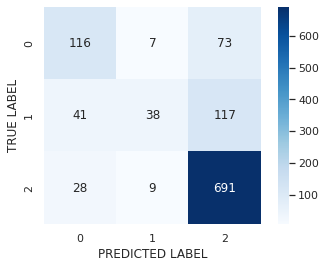

Macro F1:  0.5906141558284084
Weighted F1:  0.7180587587210394
Accuracy:  0.7544642857142857
              precision    recall  f1-score   support

    negative       0.63      0.59      0.61       196
     neutral       0.70      0.19      0.30       196
    positive       0.78      0.95      0.86       728

    accuracy                           0.75      1120
   macro avg       0.71      0.58      0.59      1120
weighted avg       0.74      0.75      0.72      1120



In [ ]:
tot = []
pre=[]
model.eval()
with torch.no_grad():
    for x,aspect_terms,aspect_polarity,lens in test_loader:

        x = x.to(device)
        aspect_polarity = aspect_polarity.to(device)
        aspect_terms = aspect_terms.to(device)

        out = model(x,aspect_terms,lens)
        loss = criterion(out,aspect_polarity)

        tot.extend(aspect_polarity.cpu())
        pre.extend(torch.argmax(out,dim=1).cpu())
    
plot_confusion_matrix(tot,pre)
print('Macro F1: ',f1_score(tot,pre,average='macro'))
print('Weighted F1: ',f1_score(tot,pre,average='weighted'))
print('Accuracy: ',accuracy_score(tot,pre))

_,cats = pd.factorize(review_test_df['AspectTermsPolarity'],sort=True)

print(classification_report(tot,pre,target_names=cats))

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# torch.save(model,'baseline.pt')